<a href="https://colab.research.google.com/github/alvin0727/TugasBesar_DeepLearning/blob/main/TugasBesar(UAS)_DeepLearning_1121061_Alvin_Boys_Gea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Library

In [ ]:
!pip install optuna
!pip install flask
!pip install flask_ngrok
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Read CSV
import pandas as pd

# Prepocessing
import re # Text Cleaning
!pip install contractions # Contraction
import contractions as contractions # Contraction
import nltk
nltk.download('punkt')  # Tokenization
nltk.download('stopwords')  # Stopwords
nltk.download('averaged_perceptron_tagger_eng')  # POS tagging
nltk.download('wordnet')  # Lemmatization
nltk.download('omw-1.4')  # WordNet Lemmatizer
from nltk.tokenize import RegexpTokenizer # Tokenization
from textblob import Word # Lemmatization
from nltk.stem import WordNetLemmatizer # Lemmatization
from nltk.corpus import wordnet # Lemmatization
from nltk.corpus import stopwords # Stopwords

# Word2vec
import multiprocessing
from gensim.models import Word2Vec
import ast

# Model
import numpy as np
import optuna
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from gensim.models import Word2Vec
import pickle

## Evaluate Model
import matplotlib.pyplot as plt

# GUI
from flask import Flask, render_template, request, jsonify
from flask_ngrok import run_with_ngrok
from pyngrok import ngrok


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 10.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Set Output Layout

In [ ]:
# Adjust Layout
pd.set_option('display.max_colwidth', None)

# 2. Class

## Class Dataframe

In [ ]:
class DataFrame:

    # Load dataframe dari Google Drive
    def load_from_drive(self, filename):
        """
        Load Dataset From Google Drive.

        Parameter:
            filename (str): File name without extension.

        Returns:
            pd.DataFrame: Dataframe that have been loaded From drive.
        """
        return pd.read_csv(f"/content/drive/MyDrive/Dataset/{filename}.csv")

    # Save dataframe ke Google Drive
    def save_to_drive(self, df, filename):
        """
        Save dataframe to Google Drive.

        Parameter:
            df (pd.DataFrame): Dataframe that will be saved.
            filename (str): File name without extension.
        """
        df.to_csv(f"/content/drive/MyDrive/Dataset/{filename}.csv", index=False)
        print("Dataframe saved to drive!")


## Class Prepocessing


In [ ]:
class Preprocessing:

    def expand_contractions(self, text):
        """
        Expand contractions in text.

        Parameter:
            text (str): Text that will be expanded.

        Returns:
            str: Expanded text.
        """

        return contractions.fix(text)

    def clean_text(self, text):
        """
        Clean text by removing URLs, special characters (excluding numbers),
        separating numbers from text, and preserving abbreviations like 'f.b.i'.

        Parameter:
            text (str): Text that will be cleaned.

        Returns:
            str: Cleaned and processed text.
        """
        # Expand contractions first
        text = self.expand_contractions(text)
        # Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        # Remove mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        # Replace dots in abbreviations (e.g., 'f.b.i' -> 'fbi')
        text = re.sub(r'\b([a-zA-Z])\.(?=[a-zA-Z])', r'\1', text)
        # Remove special characters, but keep numbers and letters
        text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove extra whitespaces
        text = text.strip()
        # Separate numbers and text
        text = ' '.join(re.findall(r'\d+|\D+', text))

        return text

    def tokenize(self, text):
        """
        Tokenize text using RegexpTokenizer.

        Parameter:
            text (str): Text that will be tokenized.

        Returns:
            list: List of tokens.
        """
        tokenizer = RegexpTokenizer(r'\w+')
        return tokenizer.tokenize(text)

    def nltk_to_wordnet(self, nltk_tag):
        """
        Convert NLTK POS tags to WordNet POS tags.

        Parameter:
            nltk_tag (str): POS tag from NLTK.

        Returns:
            str: Corresponding WordNet POS tag, or None if not recognized.
        """
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None

    def lemmatization(self, tokens):
        """
        Lemmatize tokens using WordNetLemmatizer with POS tagging.

        Parameter:
            tokens (list): List of tokens.

        Returns:
            list: List of lemmatized tokens.
        """
        lemmatizer = WordNetLemmatizer()
        pos_tags = nltk.pos_tag(tokens)  # Get POS tags using NLTK

        lemmatized_tokens = []
        for token, tag in pos_tags:
            wordnet_tag = self.nltk_to_wordnet(tag)  # Convert to WordNet POS tag
            if wordnet_tag:
                lemmatized_tokens.append(lemmatizer.lemmatize(token, wordnet_tag))
            else:
                lemmatized_tokens.append(lemmatizer.lemmatize(token))  # Default to NOUN

        return lemmatized_tokens

    def stopword_removal(self, tokens):
        """
        Remove stopwords from tokens.

        Parameter:
            tokens (list): List of tokens.

        Returns:
            list: List of tokens with stopwords removed.
        """
        # Load stopwords
        stop_words = set(stopwords.words('english'))

        # Filter tokens: exclude stopwords
        filtered_tokens = [w for w in tokens if w.lower() not in stop_words]

        return filtered_tokens

    def remove_short_words(self, tokens, min_length=3):
        """
        Remove words shorter than a specified length.

        Parameters:
            tokens (list): List of tokens.
            min_length (int): Minimum length of words to retain.

        Returns:
            list: Filtered tokens with short words removed.
        """

        return [word for word in tokens if len(word) >= min_length]

    def preprocess_pipeline(self, text, min_length=3):
        """
        Apply complete preprocessing pipeline to text.

        Parameters:
            text (str): Raw input text.
            min_length (int): Minimum word length to retain.

        Returns:
            list: Preprocessed tokens.
        """
        # Clean text
        text = self.clean_text(text)
        # Tokenize text
        tokens = self.tokenize(text)
        # Remove short words
        tokens = self.remove_short_words(tokens, min_length)
        # Lemmatize tokens
        tokens = self.lemmatization(tokens)
        # Remove stopwords
        tokens = self.stopword_removal(tokens)

        return tokens

## Class Word2vec

In [ ]:
class Word2VecTrainer:
    def __init__(self, vector_size=100, window=2, min_count=20, sample=6e-5,
                 alpha=0.03, min_alpha=0.0007, negative=20, sg=1):
        """
        Initialize the Word2VecTrainer with model parameters.

        Parameters:
            vector_size (int): Dimension of word vectors.
            window (int): Context window size.
            min_count (int): Minimum word frequency.
            sample (float): Subsampling rate for frequent words.
            alpha (float): Initial learning rate.
            min_alpha (float): Minimum learning rate.
            negative (int): Number of negative samples.
            sg (int): Training algorithm (1 for skip-gram, 0 for CBOW).
        """
        self.model = Word2Vec(
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            sample=sample,
            alpha=alpha,
            min_alpha=min_alpha,
            negative=negative,
            workers=multiprocessing.cpu_count() - 1,  # Use all cores except one
            sg=sg
        )

    def build_vocab(self, sentences):
        """
        Build the vocabulary from the provided sentences.

        Parameters:
            sentences (list): List of tokenized sentences.
        """
        self.model.build_vocab(sentences, progress_per=10000)
        print("Vocabulary built successfully!")

    def train(self, sentences, epochs=10):
        """
        Train the Word2Vec model.

        Parameters:
            sentences (list): List of tokenized sentences (list of lists of strings).
            epochs (int): Number of epochs for training.
        """
        # Validate input data format
        if not isinstance(sentences, list) or not all(isinstance(sentence, list) for sentence in sentences):
            raise ValueError("Sentences must be a list of lists of strings.")
        if not all(all(isinstance(word, str) for word in sentence) for sentence in sentences):
            raise ValueError("Each sentence must be a list of strings.")

        # Train the model
        self.model.train(
            corpus_iterable=sentences,  # Specify the corpus for training
            total_examples=len(sentences),  # Total number of sentences
            epochs=epochs  # Number of epochs
        )
        print(f"Model trained for {epochs} epochs successfully!")


    def save_model(self, path):
        """
        Save the trained Word2Vec model.

        Parameters:
            path (str): Path to save the model.
        """
        self.model.save(path)
        print(f"Model saved to {path}")

## Class Pretrained

In [ ]:
class Pretrained:
    def __init__(self, df, text_column, label_column, word2vec_path, tokenizer_path, max_length=250):
        """
        A class for tokenizing text, mapping pretrained Word2Vec embeddings, and splitting the dataset.

        Parameters:
        - df: DataFrame containing text and labels
        - text_column: Name of the column containing text data
        - label_column: Name of the column containing labels
        - word2vec_path: Path to the pretrained Word2Vec model
        - tokenizer_path: Path to save the tokenizer as a pickle file
        - max_length: Maximum sequence length for padding and truncation
        """
        self.df = df
        self.text_column = text_column
        self.label_column = label_column
        self.word2vec_path = word2vec_path
        self.tokenizer_path = tokenizer_path
        self.max_length = max_length
        self.tokenizer = Tokenizer()
        self.embedding_matrix = None
        self.embedding_dim = None
        self.vocab_size = None
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None

    def tokenize_text(self):
        """Tokenizes the text and saves the tokenizer."""
        self.tokenizer.fit_on_texts(self.df[self.text_column])
        self.df['sequences'] = self.tokenizer.texts_to_sequences(self.df[self.text_column])

        with open(self.tokenizer_path, "wb") as f:
            pickle.dump(self.tokenizer, f)
        print(f"Tokenizer saved successfully at {self.tokenizer_path}")

    def pad_sequences(self):
        """Pads sequences to ensure uniform length."""
        return pad_sequences(
            self.df['sequences'],
            maxlen=self.max_length,
            padding='post',   # Adds padding at the end of the sequence
            truncating='post' # Truncates sequences longer than max_length at the end
        )

    def load_word2vec(self):
        """Loads the Word2Vec model and creates the embedding matrix."""
        word2vec_model = Word2Vec.load(self.word2vec_path)
        self.embedding_dim = word2vec_model.vector_size
        self.vocab_size = len(self.tokenizer.word_index) + 1

        self.embedding_matrix = np.zeros((self.vocab_size, self.embedding_dim))
        for word, i in self.tokenizer.word_index.items():
            if word in word2vec_model.wv:
                self.embedding_matrix[i] = word2vec_model.wv[word]

        print(f"Word2Vec model loaded successfully from {self.word2vec_path}")
        print(f"Embedding matrix shape: {self.embedding_matrix.shape}")

    def split_data(self):
        """Splits the dataset into training and testing sets."""
        X = self.pad_sequences()
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X,
            self.df[self.label_column],
            test_size=0.2,
            random_state=42,
            shuffle=True
        )
        print(f"Dataset split successfully: {len(self.X_train)} train samples, {len(self.X_test)} test samples.")

    def process(self):
        """Executes all steps in a single process."""
        self.tokenize_text()
        self.load_word2vec()
        self.split_data()
        return self.X_train, self.X_test, self.y_train, self.y_test, self.embedding_matrix, self.vocab_size, self.embedding_dim

## Class Train

In [ ]:
class LSTMHyperparameterTuner:
    def __init__(self, X_train, y_train, X_test, y_test, embedding_matrix, vocab_size, embedding_dim, max_length=250):
        """
        A class to perform hyperparameter tuning using Optuna for an LSTM model with pretrained embeddings.

        Parameters:
        - X_train, y_train: Training dataset
        - X_test, y_test: Test dataset
        - embedding_matrix: Pretrained word embedding matrix
        - vocab_size: Vocabulary size
        - embedding_dim: Dimension of word embeddings
        - max_length: Maximum sequence length for padding
        """
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.embedding_matrix = embedding_matrix
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.best_model = None
        self.best_hyperparams = None

        # Path to save trained model and training history
        self.model_path = "/content/drive/MyDrive/Model_UAS/trained_model.keras"
        self.history_path = "/content/drive/MyDrive/Log/training_history.csv"

        # Check if GPU is available
        self.device_name = "/device:GPU:0" if tf.config.list_physical_devices('GPU') else "/cpu:0"
        print(f"Using {self.device_name} for training.")

    def build_model(self, learning_rate):
        """Builds and compiles an LSTM model with the given learning rate."""
        model = Sequential([
            Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, weights=[self.embedding_matrix], trainable=False),

            LSTM(128, return_sequences=True),
            Dropout(0.3),

            LSTM(64, return_sequences=False),
            Dropout(0.5),

            Dense(32, activation='relu'),
            Dropout(0.2),

            Dense(1, activation='sigmoid')
        ])

        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def objective(self, trial):
        """Objective function for Optuna to optimize hyperparameters."""
        learning_rate = trial.suggest_float("learning_rate", 1e-6, 3e-5, log=True)
        batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
        epochs = trial.suggest_int("epochs", 5, 50)

        model = self.build_model(learning_rate)

        history = model.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=0
        )

        val_accuracy = max(history.history['val_accuracy'])  # Get the highest validation accuracy
        return val_accuracy

    def tune_hyperparameters(self, n_trials=10):
        """Runs Optuna hyperparameter tuning and stores the best parameters."""
        study = optuna.create_study(direction="maximize")
        study.optimize(self.objective, n_trials=n_trials)

        self.best_hyperparams = study.best_params
        print("\nBest Hyperparameters:", self.best_hyperparams,"\n")

    def train_best_model(self):
        """Trains the model using the best hyperparameters and saves the model & training history."""
        best_learning_rate = self.best_hyperparams['learning_rate']
        best_batch_size = self.best_hyperparams['batch_size']
        best_epochs = self.best_hyperparams['epochs']

        self.best_model = self.build_model(best_learning_rate)

        history = self.best_model.fit(
            self.X_train, self.y_train,
            epochs=best_epochs,
            batch_size=best_batch_size,
            validation_split=0.2,
            verbose=1
        )

        # ✅ Save model in .keras format to the specified path
        self.best_model.save(self.model_path, save_format="keras")
        print(f"Best model saved at {self.model_path}")

        # ✅ Save training history as CSV
        history_df = pd.DataFrame({
            "epoch": list(range(1, best_epochs + 1)),
            "train_accuracy": history.history["accuracy"],
            "val_accuracy": history.history["val_accuracy"],
            "train_loss": history.history["loss"],
            "val_loss": history.history["val_loss"]
        })
        history_df.to_csv(self.history_path, index=False)
        print(f"Training history saved at {self.history_path}")

    def evaluate_model(self):
        """Evaluates the trained model on the test set and prints metrics."""
        if self.best_model is None:
            raise ValueError("No trained model found. Please run train_best_model() first.")

        y_pred = self.best_model.predict(self.X_test).round().astype(int)
        test_accuracy = accuracy_score(self.y_test, y_pred)
        test_f1 = f1_score(self.y_test, y_pred)

        print(f"\nTest Accuracy: {test_accuracy:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")

        # Generate and print confusion matrix
        cm = confusion_matrix(self.y_test, y_pred)
        cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
        print("\nConfusion Matrix:")
        print(cm_df)

    def run(self, n_trials=10):
        with tf.device(self.device_name):
            """Runs the entire process: hyperparameter tuning, training, and evaluation."""
            print("\n🔍 Running hyperparameter tuning...")
            self.tune_hyperparameters(n_trials)

            print("\n📌 Training the best model...")
            self.train_best_model()

            print("\n📊 Evaluating the model...")
            self.evaluate_model()

## Class Predict


In [ ]:
class Predict:
    def __init__(self, model_path, tokenizer_path, preprocessing_instance, max_length=250, threshold=0.5):
        """
        A class for loading a trained LSTM model, processing text inputs, and making predictions.

        Parameters:
        - model_path: Path to the saved Keras model (.keras format)
        - tokenizer_path: Path to the saved tokenizer pickle file
        - preprocessing_instance: An instance of the Preprocessing class for text cleaning
        - max_length: Maximum sequence length for padding/truncation
        - threshold: Decision threshold for binary classification (default: 0.5)
        """
        self.model_path = model_path
        self.tokenizer_path = tokenizer_path
        self.preprocessing_instance = preprocessing_instance
        self.max_length = max_length
        self.threshold = threshold

        # Load the trained model
        self.model = tf.keras.models.load_model(self.model_path)
        print(f"✅ Model loaded successfully from {self.model_path}")

        # Load the tokenizer
        with open(self.tokenizer_path, "rb") as f:
            self.tokenizer = pickle.load(f)
        print(f"✅ Tokenizer loaded successfully from {self.tokenizer_path} \n")

    def preprocess_text(self, text):
        """
        Preprocesses input text using the Preprocessing class and converts it into token sequences.
        """
        processed_text = self.preprocessing_instance.preprocess_pipeline(text)  # Use preprocessing instance
        tokens = self.tokenizer.texts_to_sequences([processed_text])

        # Pad sequences to ensure uniform length
        padded_tokens = pad_sequences(tokens, maxlen=self.max_length, padding='post', truncating='post')

        return padded_tokens

    def predict(self, text):
        """
        Predicts the class of a given text input using the trained LSTM model.

        Parameters:
        - text: The raw input text to classify

        Returns:
        - predictions: The raw probability scores from the model
        - predicted_class: The final class label (0 or 1) based on the threshold
        """
        padded_tokens = self.preprocess_text(text)

        # Make prediction
        predictions = self.model.predict(padded_tokens)

        # Convert predictions to binary class (0 or 1)
        predicted_class = (predictions >= self.threshold).astype(int)

        return predictions, predicted_class

    def classify(self, text):
        """
        Processes input text and returns the predicted class with probability.
        """
        predictions, predicted_class = self.predict(text)

        print(f"\n🔍 Input Text: {text}")
        print(f"📊 Prediction Score: {predictions[0][0]:.4f}")
        print(f"✅ Predicted Class: {predicted_class[0][0]}")

        return predicted_class[0][0], predictions[0][0]

## Class GUI


In [ ]:
class GUI:
    def __init__(self):
        """
        Initializes the Flask app and sets up paths for the model, tokenizer, and preprocessing.
        """
        # Define paths to template and static folders
        template_path = "/content/drive/MyDrive/GUI_UAS/templates"
        static_path = "/content/drive/MyDrive/GUI_UAS/static"

        # Define paths to the trained model and tokenizer
        model_path = "/content/drive/MyDrive/Model_UAS/trained_model.keras"
        tokenizer_path = "/content/drive/MyDrive/Model_UAS/tokenizer.pkl"

        # Initialize Flask app
        self.app = Flask(__name__, template_folder=template_path, static_folder=static_path)

        # Initialize preprocessing and prediction model
        self.preprocessor = Preprocessing()
        self.predictor = Predict(model_path, tokenizer_path, self.preprocessor)

    def start_gui(self):
        """
        Starts the Flask web application using Ngrok.
        """
        run_with_ngrok(self.app)  # Enable public access via Ngrok

        @self.app.route("/", methods=["GET", "POST"])
        def home():
            """
            Renders the main page and handles text classification.
            """
            prediction = None
            probability = None

            if request.method == "POST":
                user_input = request.form["user_input"]

                if not user_input.strip():
                    return render_template("index.html", error="Input text cannot be empty.")

                try:
                    # Perform classification
                    predicted_label, probability = self.predictor.classify(user_input)

                    # Assign label based on prediction result
                    label = "Positive" if predicted_label == 1 else "Negative"

                    return render_template(
                        "index.html",
                        result=predicted_label,
                        label=label,
                        probability=round(probability, 4),  # Limit to 4 decimal places
                    )

                except Exception as e:
                    # Handle errors and display them to the user
                    return render_template("index.html", error=f"An error occurred: {e}")

            return render_template("index.html")

        self.app.run()

# 3. Prepocessing (No Need Re-run)

In [ ]:
dataframe = DataFrame()
prepocessor = Preprocessing()

## Load Original Data

In [ ]:
df1 = dataframe.load_from_drive("Fake")
df1.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before th

In [ ]:
df2 = dataframe.load_from_drive("True")
df2.head()

title  \
0       As U.S. budget fight looms, Republicans flip their fiscal script   
1       U.S. military to accept transgender recruits on Monday: Pentagon   
2           Senior U.S. Republican senator: 'Let Mr. Mueller do his job'   
3            FBI Russia probe helped by Australian diplomat tip-off: NYT   
4  Trump wants Postal Service to charge 'much more' for Amazon shipments   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
# Add field Label
df1['label'] = '1'
df2['label'] = '0'

# Combined Dataset
combined_df = pd.concat([df1, df2], ignore_index=True)
drop_columns = ['title', 'subject', 'date']
combined_df = combined_df.drop(drop_columns, axis=1)
combined_df.head()

,text,label
0,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",1
1,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the former aide set up meetings with world leaders for Trump, but team Trump ran with him being merely a coffee boy.In May 2016, Papadopoulos revealed to Australian diplomat Alexand

## Text Cleaning

In [ ]:
# Text Cleaning
text_cleaning = combined_df['text'].apply(prepocessor.clean_text)
text_cleaning.head(2)

,text
0,donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to his enemies haters and the very dishonest fake news media the former reality show star had just one job to do and he couldn t do it as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year president angry pants tweeted 2018 will be a great year for america as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year 2018 will be a great year for america donald j trump december 31 2017 trump s tweet went down about as welll as you d expectwhat kind of president sends a new year s greeting like this despicable petty infantile gibberish only trump his lack of decency won t even allow him to rise above the gutter long enough to wish the american citizens a happy new year bishop talbert swan december 31 2017 no one likes you calvin december 31 2017 your impeachment would make 2018 a great year for america but i ll also accept regaining control of congress miranda yaver december 31 2017 do you hear yourself talk when you have to include that many people that hate you you have to wonder why do the they all hate me alan sandoval december 31 2017 who uses the word haters in a new years wish marlene december 31 2017 you can t just say happy new year koren pollitt december 31 2017 here s trump s new year s eve tweet from 2016 happy new year to all including to my many enemies and those who have fought me and lost so badly they just don t know what to do love donald j trump december 31 2016 this is nothing new for trump he s been doing this for yearstrump has directed messages to his enemies and haters for new year s easter thanksgiving and the anniversary of 911 pictwittercom 4 fpae 2 kypa daniel dale december 31 2017 trump s holiday tweets are clearly not presidentialhow long did he work at hallmark before becoming president steven goodine december 31 2017 he s always been like this the only difference is that in the last few years his filter has been breaking down roy schulze december 31 2017 who apart from a teenager uses the term haters wendy december 31 2017 he s a fucking 5 year old who knows december 31 2017 so to all the people who voted for this a hole thinking he would change once he got into power you were wrong 70 yearold men don t change and now he s a year olderphoto by andrew burtongetty images
1,house intelligence committee chairman devin nunes is going to have a bad day he s been under the assumption like many of us that the christopher steeledossier was what prompted the russia investigation so he s been lashing out at the department of justice and the fbi in order to protect trump as it happens the dossier is not what started the investigation according to documents obtained by the new york timesformer trump campaign adviser george papadopoulos was drunk in a wine bar when he revealed knowledge of russian opposition research on hillary clintonon top of that papadopoulos wasn t just a covfefe boy for trump as his administration has alleged he had a much larger role but none so damning as being a drunken fool in a wine bar coffee boys don t help to arrange a new york meeting between trump and president abdel fattah elsisi of egypt two months before the election it was known before that the former aide set up meetings with world leaders for trump but team trump ran with him being merely a coffee boyin may 2016 papadopoulos revealed to australian diplomat alexander downer that russian officials were shopping around possible dirt on thendemocratic presidential nominee hillary clinton exactly how much mr papadopoulos said that night at the kensington wine rooms with the australian alexander downer is unclear the report states but two months later when leak

## Tokenization

In [ ]:
tokens = text_cleaning.apply(prepocessor.tokenize)
tokens.head(2)

,text
0,"[donald, trump, just, couldn, t, wish, all, americans, a, happy, new, year, and, leave, it, at, that, instead, he, had, to, give, a, shout, out, to, his, enemies, haters, and, the, very, dishonest, fake, news, media, the, former, reality, show, star, had, just, one, job, to, do, and, he, couldn, t, do, it, as, our, country, rapidly, grows, stronger, and, smarter, i, want, to, wish, all, of, my, friends, supporters, enemies, haters, and, even, the, very, dishonest, fake, news, media, a, happy, and, healthy, new, year, president, angry, pants, tweeted, 2018, will, be, a, great, year, for, america, as, our, ...]"
1,"[house, intelligence, committee, chairman, devin, nunes, is, going, to, have, a, bad, day, he, s, been, under, the, assumption, like, many, of, us, that, the, christopher, steeledossier, was, what, prompted, the, russia, investigation, so, he, s, been, lashing, out, at, the, department, of, justice, and, the, fbi, in, order, to, protect, trump, as, it, happens, the, dossier, is, not, what, started, the, investigation, according, to, documents, obtained, by, the, new, york, timesformer, trump, campaign, adviser, george, papadopoulos, was, drunk, in, a, wine, bar, when, he, revealed, knowledge, of, russian, opposition, research, on, hillary, clintonon, top, of, that, papadopoulos, wasn, t, ...]"


## Remove Short Word

In [ ]:
remove_short_words = tokens.apply(prepocessor.remove_short_words)
remove_short_words.head(2)

,text
0,"[donald, trump, just, couldn, wish, all, americans, happy, new, year, and, leave, that, instead, had, give, shout, out, his, enemies, haters, and, the, very, dishonest, fake, news, media, the, former, reality, show, star, had, just, one, job, and, couldn, our, country, rapidly, grows, stronger, and, smarter, want, wish, all, friends, supporters, enemies, haters, and, even, the, very, dishonest, fake, news, media, happy, and, healthy, new, year, president, angry, pants, tweeted, 2018, will, great, year, for, america, our, country, rapidly, grows, stronger, and, smarter, want, wish, all, friends, supporters, enemies, haters, and, even, the, very, dishonest, fake, news, media, happy, and, ...]"
1,"[house, intelligence, committee, chairman, devin, nunes, going, have, bad, day, been, under, the, assumption, like, many, that, the, christopher, steeledossier, was, what, prompted, the, russia, investigation, been, lashing, out, the, department, justice, and, the, fbi, order, protect, trump, happens, the, dossier, not, what, started, the, investigation, according, documents, obtained, the, new, york, timesformer, trump, campaign, adviser, george, papadopoulos, was, drunk, wine, bar, when, revealed, knowledge, russian, opposition, research, hillary, clintonon, top, that, papadopoulos, wasn, just, covfefe, boy, for, trump, his, administration, has, alleged, had, much, larger, role, but, none, damning, being, drunken, fool, wine, bar, coffee, boys, don, help, arrange, ...]"


## Lemmatization

In [ ]:
tokens_lemma = remove_short_words.apply(prepocessor.lemmatization)
tokens_lemma.head(2)

,text
0,"[donald, trump, just, couldn, wish, all, american, happy, new, year, and, leave, that, instead, have, give, shout, out, his, enemy, hater, and, the, very, dishonest, fake, news, medium, the, former, reality, show, star, have, just, one, job, and, couldn, our, country, rapidly, grow, strong, and, smarter, want, wish, all, friends, supporter, enemy, hater, and, even, the, very, dishonest, fake, news, medium, happy, and, healthy, new, year, president, angry, pant, tweeted, 2018, will, great, year, for, america, our, country, rapidly, grow, strong, and, smarter, want, wish, all, friends, supporter, enemy, hater, and, even, the, very, dishonest, fake, news, medium, happy, and, ...]"
1,"[house, intelligence, committee, chairman, devin, nunes, go, have, bad, day, be, under, the, assumption, like, many, that, the, christopher, steeledossier, be, what, prompt, the, russia, investigation, be, lash, out, the, department, justice, and, the, fbi, order, protect, trump, happen, the, dossier, not, what, start, the, investigation, accord, document, obtain, the, new, york, timesformer, trump, campaign, adviser, george, papadopoulos, be, drunk, wine, bar, when, reveal, knowledge, russian, opposition, research, hillary, clintonon, top, that, papadopoulos, wasn, just, covfefe, boy, for, trump, his, administration, have, allege, have, much, large, role, but, none, damning, be, drunken, fool, wine, bar, coffee, boys, don, help, arrange, ...]"


## Stopword Removal

In [ ]:
stopword_removal = tokens_lemma.apply(prepocessor.stopword_removal)
stopword_removal.head(2)

,text
0,"[donald, trump, wish, american, happy, new, year, leave, instead, give, shout, enemy, hater, dishonest, fake, news, medium, former, reality, show, star, one, job, country, rapidly, grow, strong, smarter, want, wish, friends, supporter, enemy, hater, even, dishonest, fake, news, medium, happy, healthy, new, year, president, angry, pant, tweeted, 2018, great, year, america, country, rapidly, grow, strong, smarter, want, wish, friends, supporter, enemy, hater, even, dishonest, fake, news, medium, happy, healthy, new, year, 2018, great, year, america, donald, trump, december, 2017, trump, tweet, go, welll, expectwhat, kind, president, send, new, year, greet, like, despicable, petty, infantile, gibberish, trump, lack, decency, win, even, ...]"
1,"[house, intelligence, committee, chairman, devin, nunes, go, bad, day, assumption, like, many, christopher, steeledossier, prompt, russia, investigation, lash, department, justice, fbi, order, protect, trump, happen, dossier, start, investigation, accord, document, obtain, new, york, timesformer, trump, campaign, adviser, george, papadopoulos, drunk, wine, bar, reveal, knowledge, russian, opposition, research, hillary, clintonon, top, papadopoulos, covfefe, boy, trump, administration, allege, much, large, role, none, damning, drunken, fool, wine, bar, coffee, boys, help, arrange, new, york, meeting, trump, president, abdel, fattah, elsisi, egypt, two, month, election, know, former, aide, set, meeting, world, leader, trump, team, trump, run, merely, coffee, boyin, may, 2016, papadopoulos, reveal, australian, ...]"


## Save Dataset

In [ ]:
combined_df.loc[:, 'feature'] = stopword_removal
df_new = combined_df[['feature', 'label']]
dataframe.save_to_drive(df_new, "Ready_Dataset")

Dataframe saved to drive!


# 4. Create Word2vec Model

In [ ]:
dataframe = DataFrame()


## Load Dataset

In [ ]:
ready_df = dataframe.load_from_drive("Ready_Dataset")

# convert to list
ready_df['feature'] = ready_df['feature'].apply(eval)
sentences = ready_df['feature'].tolist()
print(sentences[:2])


[['donald', 'trump', 'wish', 'american', 'happy', 'new', 'year', 'leave', 'instead', 'give', 'shout', 'enemy', 'hater', 'dishonest', 'fake', 'news', 'medium', 'former', 'reality', 'show', 'star', 'one', 'job', 'country', 'rapidly', 'grow', 'strong', 'smarter', 'want', 'wish', 'friends', 'supporter', 'enemy', 'hater', 'even', 'dishonest', 'fake', 'news', 'medium', 'happy', 'healthy', 'new', 'year', 'president', 'angry', 'pant', 'tweeted', '2018', 'great', 'year', 'america', 'country', 'rapidly', 'grow', 'strong', 'smarter', 'want', 'wish', 'friends', 'supporter', 'enemy', 'hater', 'even', 'dishonest', 'fake', 'news', 'medium', 'happy', 'healthy', 'new', 'year', '2018', 'great', 'year', 'america', 'donald', 'trump', 'december', '2017', 'trump', 'tweet', 'go', 'welll', 'expectwhat', 'kind', 'president', 'send', 'new', 'year', 'greet', 'like', 'despicable', 'petty', 'infantile', 'gibberish', 'trump', 'lack', 'decency', 'win', 'even', 'allow', 'rise', 'gutter', 'long', 'enough', 'wish', 'am

## Initialize Word2vec Model

In [ ]:
trainer = Word2VecTrainer(
    vector_size=100,
    window=2,
    min_count=10,
    sample=6e-5,
    alpha=0.03,
    min_alpha=0.0007,
    negative=20,
    sg=1
)


## Build Vocab

In [ ]:
trainer.build_vocab(sentences)

Vocabulary built successfully!


## Train Model

In [ ]:
trainer.train(sentences, epochs=10)

Model trained for 10 epochs successfully!


## Save Word2vec Model

In [ ]:
trainer.save_model("/content/drive/MyDrive/Model_UAS/word2vec_model_SG1.model")


Model saved to /content/drive/MyDrive/Model_UAS/word2vec_model_SG1.model


# 5 Train Classfication

## Load dataset

In [ ]:
dataframe = DataFrame()
df = dataframe.load_from_drive("Ready_Dataset")
df['feature'] = df['feature'].apply(eval)
average_tokens = df['feature'].apply(len).mean()
print(f"Average tokens: {average_tokens}")

Average tokens: 228.14826941066417


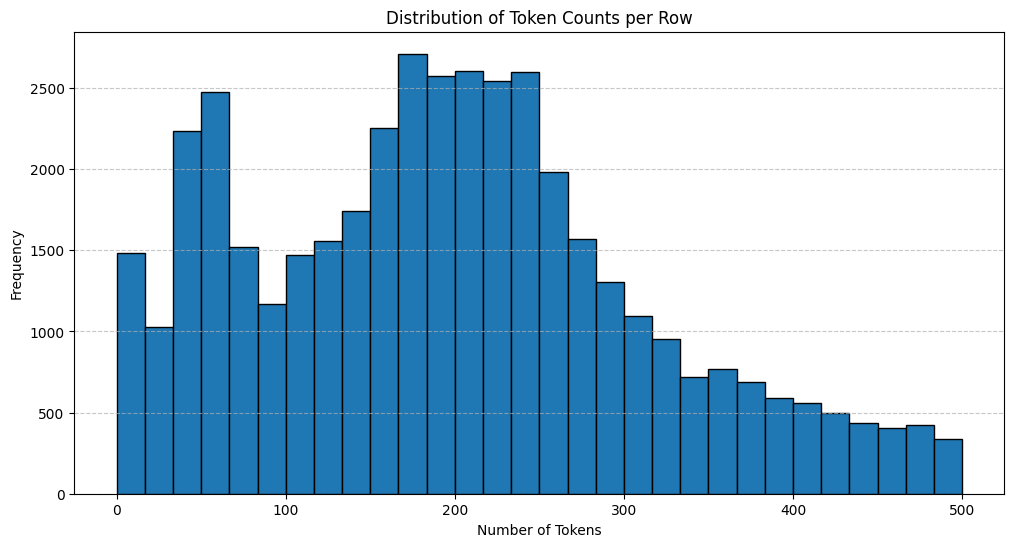

In [ ]:
# Calculate the token counts for each row
token_counts = df['feature'].apply(len)

plt.figure(figsize=(12, 6))
plt.hist(token_counts, bins=30, range=(0,500), edgecolor='black')
plt.title("Distribution of Token Counts per Row")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Pretrained

In [ ]:
# Initialize class
pretrained_processor = Pretrained(
    df=df,  # DataFrame
    text_column='feature',  # Feature Column
    label_column='label',  # Label
    word2vec_path="/content/drive/MyDrive/Model_UAS/word2vec_model_SG1.model",
    tokenizer_path="/content/drive/MyDrive/Model_UAS/tokenizer.pkl",
    max_length=250  # Max Sequnce
)

# Run (tokenisasi, embedding, and dataset split)
X_train, X_test, y_train, y_test, embedding_matrix, vocab_size, embedding_dim = pretrained_processor.process()


Tokenizer saved successfully at /content/drive/MyDrive/Model_UAS/tokenizer.pkl
Word2Vec model loaded successfully from /content/drive/MyDrive/Model_UAS/word2vec_model_SG1.model
Embedding matrix shape: (196851, 100)
Dataset split successfully: 35918 train samples, 8980 test samples.


## Trained

In [ ]:
# Initialize the tuner
tuner = LSTMHyperparameterTuner(
    X_train, y_train, X_test, y_test,
    embedding_matrix, vocab_size, embedding_dim
)

# Run the full training process
tuner.run(n_trials=10)

[I 2025-01-07 18:40:23,253] A new study created in memory with name: no-name-4709df74-7f7e-47a1-8c85-9c8ac67e7007


Using /device:GPU:0 for training.

🔍 Running hyperparameter tuning...


[I 2025-01-07 18:53:00,192] Trial 0 finished with value: 0.9207962155342102 and parameters: {'learning_rate': 1.927223967118402e-06, 'batch_size': 32, 'epochs': 33}. Best is trial 0 with value: 0.9207962155342102.
[I 2025-01-07 19:08:48,035] Trial 1 finished with value: 0.9280345439910889 and parameters: {'learning_rate': 3.4557319142214747e-06, 'batch_size': 32, 'epochs': 47}. Best is trial 1 with value: 0.9280345439910889.
[I 2025-01-07 19:23:42,899] Trial 2 finished with value: 0.9276169538497925 and parameters: {'learning_rate': 1.3110942368093524e-06, 'batch_size': 32, 'epochs': 44}. Best is trial 1 with value: 0.9280345439910889.
[I 2025-01-07 19:27:14,369] Trial 3 finished with value: 0.9407015442848206 and parameters: {'learning_rate': 1.9257184415974237e-05, 'batch_size': 128, 'epochs': 22}. Best is trial 3 with value: 0.9407015442848206.
[I 2025-01-07 19:28:57,179] Trial 4 finished with value: 0.9479398727416992 and parameters: {'learning_rate': 1.1041123576008157e-05, 'batch


Best Hyperparameters: {'learning_rate': 7.408570091073e-06, 'batch_size': 32, 'epochs': 35} 


📌 Training the best model...
Epoch 1/35
898/898 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.5343 - loss: 0.6920 - val_accuracy: 0.5864 - val_loss: 0.6769
Epoch 2/35
898/898 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6064 - loss: 0.6660 - val_accuracy: 0.8749 - val_loss: 0.5295
Epoch 3/35
898/898 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.8892 - loss: 0.4441 - val_accuracy: 0.9166 - val_loss: 0.2939
Epoch 4/35
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9189 - loss: 0.3082 - val_accuracy: 0.9369 - val_loss: 0.2395
Epoch 5/35
898/898 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.9351 - loss: 0.2637 - val_accuracy: 0.9376 - val_loss: 0.2370
Epoch 6/35
898/898 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9320 - loss: 0.2698 - val_accuracy: 0.8960 - val_loss: 0.3313
Epoch 7/35
898/898 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9087 - loss: 0.3043 - val_a

Best model saved at /content/drive/MyDrive/Model_UAS/trained_model.keras
Training history saved at /content/drive/MyDrive/Log/training_history.csv

📊 Evaluating the model...
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

Test Accuracy: 0.9624
Test F1-Score: 0.9646

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                4039                 208
Actual Positive                 130                4603


## Plot of evaluate model

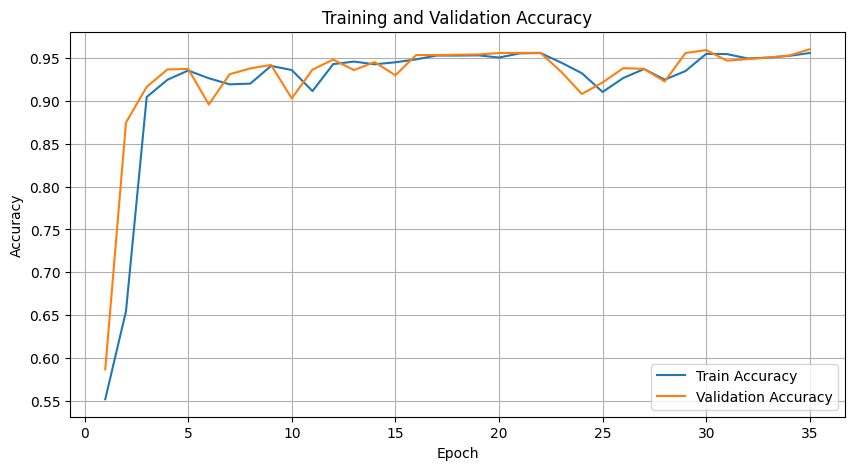

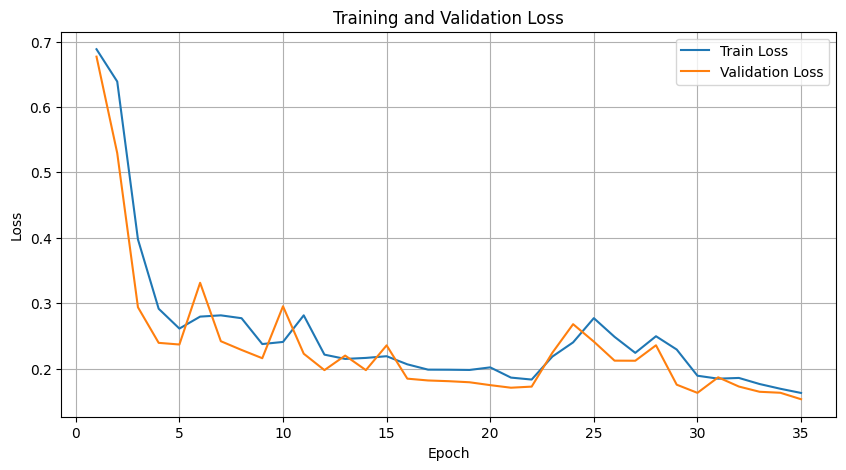

In [ ]:
# Load CSV file
file_path = "/content/drive/MyDrive/Log/training_history.csv"
df_history = pd.read_csv(file_path)

# Convert epoch
df_history["epoch"] = df_history["epoch"].astype(int)

# Create plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(df_history["epoch"], df_history["train_accuracy"], label="Train Accuracy")
plt.plot(df_history["epoch"], df_history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Create plot Loss
plt.figure(figsize=(10, 5))
plt.plot(df_history["epoch"], df_history["train_loss"], label="Train Loss")
plt.plot(df_history["epoch"], df_history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# 6. GUI

In [ ]:
# Replace 'YOUR_NGROK_AUTH_TOKEN' with your actual ngrok authtoken
ngrok.set_auth_token("")
public_url = ngrok.connect(5000)

gui = GUI()
gui.start_gui()

✅ Model loaded successfully from /content/drive/MyDrive/Model_UAS/trained_model.keras
✅ Tokenizer loaded successfully from /content/drive/MyDrive/Model_UAS/tokenizer.pkl 

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://5086-34-105-86-126.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [02/Feb/2025 06:24:01] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Feb/2025 06:24:03] "GET /static/style.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Feb/2025 06:24:04] "GET /favicon.ico HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


INFO:werkzeug:127.0.0.1 - - [02/Feb/2025 06:26:31] "POST / HTTP/1.1" 200 -



🔍 Input Text: You had to feel for Bournemouth manager Andoni Iraola, coming into this game as he did with a frankly ludicrous nine first-team players missing through injury.

Liverpool, meanwhile, arrived on the south coast with every single player fit, a rare situation that meant stars such as Joe Gomez and Federico Chiesa had to be left out of the squad entirely.

Contrast that to this point last season, when the Reds were going through a similar crisis to their opponents all while being expected to keep up Premier League title-winning pace.

That they have thus far avoided those problems could well prove to be the reason they get over the line this time around.

It might also mean more people recognise that, in a normal campaign not beset by a freakish number of fitness issues, Liverpool possess the strongest squad in the division.

Trent Alexander-Arnold‘s withdraw will be a concern and Slot explained that “he felt something” but “I cannot tell you exactly what it is and how bad i

INFO:werkzeug:127.0.0.1 - - [02/Feb/2025 06:26:32] "GET /static/style.css HTTP/1.1" 304 -
